<a href="https://colab.research.google.com/github/hahaslav/Labworks_SMAM_Lab_2/blob/main/%D0%86%D0%BC%D1%96%D1%82%D0%B0%D1%86%D1%96%D0%B9%D0%BD%D0%B5_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D1%8E%D0%B2%D0%B0%D0%BD%D0%BD%D1%8F_%D0%B2_%D1%82%D0%B5%D0%BE%D1%80%D1%96%D1%97_%D0%B9%D0%BC%D0%BE%D0%B2%D1%96%D1%80%D0%BD%D0%BE%D1%81%D1%82%D1%96.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Робота №2

## Імітаційне моделювання в теорії ймовірності

Роботу виконала Бригада №1 у складі: Панчук Ігор(ком.), Шеметов Ярослав та Попович Марія.

#### Імпорт необхідних бібліотек

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

### 1. Моделювання вибірок

In [3]:
rand_exp = np.random.exponential(scale=1, size=100)
rand_norm = np.random.normal(loc=0, scale=2, size=1000)
rand_extrem = stats.genextreme.rvs(c=1, loc=0, scale=1, size=10000)

### 2. Перевірка належності до розподілів

#### 2.1) Критерій Колмогорова-Смирнова

In [4]:
# Estimate the lambda parameter for the exponential distribution
lambda_estimate = 1 / np.mean(rand_exp)

# Perform the K-S test against an exponential distribution with the estimated lambda
exp_ks_statistic, exp_p_value = stats.kstest(rand_exp, 'expon', args=(0, 1/lambda_estimate))

print(f"Exponential Distribution: KS Statistic = {exp_ks_statistic:f}, p-value = {exp_p_value:f}")

# Estimate the parameters for the normal distribution (mean and std)
mean_estimate = np.mean(rand_norm)
std_estimate = np.std(rand_norm)

# Perform the K-S test against a normal distribution with the estimated parameters
normal_ks_statistic, normal_p_value = stats.kstest(rand_norm, 'norm', args=(mean_estimate, std_estimate))

print(f"Normal Distribution: KS Statistic = {normal_ks_statistic:f}, p-value = {normal_p_value:f}")

shape, loc, scale = stats.genextreme.fit(rand_extrem)

# Perform the K-S test against the GEV distribution
extrem_ks_statistic, extrem_p_value = stats.kstest(rand_extrem, 'genextreme', args=(shape, loc, scale))

print(f"GEV Distribution: KS Statistic = {extrem_ks_statistic:f}, p-value = {extrem_p_value:f}")

Exponential Distribution: KS Statistic = 0.052719, p-value = 0.929973
Normal Distribution: KS Statistic = 0.015093, p-value = 0.974086
GEV Distribution: KS Statistic = 0.006251, p-value = 0.827062


#### 2.2) Критерій $\omega^2$

In [5]:
# Calculate the ECDF
def ecdf(data):
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n + 1) / n
    return x, y

exp_x, exp_ecdf_values = ecdf(rand_exp)
normal_x, normal_ecdf_values = ecdf(rand_norm)
extrem_x, extrem_ecdf_values = ecdf(rand_extrem)

# Estimate parameters of the distributions
# Exponential Distribution (estimate lambda)
lambda_exp = 1 / np.mean(rand_exp)

# Normal Distribution (estimate mean and std)
mu, std = np.mean(rand_norm), np.std(rand_norm)

# Extreme Value Distribution (Gumbel) parameters
params_extreme = stats.gumbel_r.fit(rand_extrem)

# Compute the theoretical CDFs for each distribution
# Exponential CDF
cdf_exp = stats.expon.cdf(exp_x, scale=1/lambda_exp)

# Normal CDF
cdf_normal = stats.norm.cdf(normal_x, loc=mu, scale=std)

# Extreme Value CDF
cdf_extreme = stats.gumbel_r.cdf(extrem_x, *params_extreme)

# Calculate the ω² statistic for each distribution
def omega_squared(ecdf_values, cdf_values):
    n = len(ecdf_values)
    omega2 = np.sum((cdf_values - (2 * np.arange(1, n + 1) - 1) / (2 * n))**2) + 1 / (12 * n)
    p_value = stats.kstwobign.sf(np.sqrt(n) * np.sqrt(omega2))
    return omega2, p_value

# Calculate ω² for each distribution
omega2_exp, o_p_exp = omega_squared(exp_ecdf_values, cdf_exp)
omega2_norm, o_p_norm = omega_squared(normal_ecdf_values, cdf_normal)
omega2_extrem, o_p_extrem = omega_squared(extrem_ecdf_values, cdf_extreme)

print(f"ω² for Exponential Distribution: {omega2_exp:f}, p-value: {o_p_exp}")
print(f"ω² for Normal Distribution: {omega2_norm:f}, p-value: {o_p_norm}")
print(f"ω² for Extreme Value Distribution: {omega2_extrem:f}, p-value: {o_p_extrem}")

ω² for Exponential Distribution: 0.024791, p-value: 0.014050097072052677
ω² for Normal Distribution: 0.042281, p-value: 3.768293076159044e-37
ω² for Extreme Value Distribution: 196.434514, p-value: 0.0


#### 2.3) Критерій $\chi^2$

In [6]:
# Functions to perform chi-squared tests
def chi_squared_test(observed_freq, expected_freq):
    # Normalize the expected frequencies to match the sum of the observed frequencies
    expected_freq *= observed_freq.sum() / expected_freq.sum()

    chi2_stat, p_value = stats.chisquare(f_obs=observed_freq, f_exp=expected_freq)
    return chi2_stat, p_value

def test_exponential_distribution(data):
    num_bins = 10
    observed_freq, bin_edges = np.histogram(data, bins=num_bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Fit the exponential distribution to the data
    loc, scale = stats.expon.fit(data)

    # Calculate expected frequencies based on the fitted distribution
    expected_freq = np.diff(stats.expon.cdf(bin_edges, loc=loc, scale=scale)) * len(data)

    # Perform chi-squared test
    chi2_stat, p_value = chi_squared_test(observed_freq, expected_freq)
    print(f"Exponential Distribution: Chi2 Stat={chi2_stat:f}, p-value={p_value:f}")
    return p_value

def test_normal_distribution(data):
    num_bins = 10
    observed_freq, bin_edges = np.histogram(data, bins=num_bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Fit the normal distribution to the data
    mu, std = stats.norm.fit(data)

    # Calculate expected frequencies based on the fitted distribution
    expected_freq = np.diff(stats.norm.cdf(bin_edges, loc=mu, scale=std)) * len(data)

    # Perform chi-squared test
    chi2_stat, p_value = chi_squared_test(observed_freq, expected_freq)
    print(f"Normal Distribution: Chi2 Stat={chi2_stat:f}, p-value={p_value:f}")
    return p_value

def test_extreme_value_distribution(data):
    num_bins = 10
    observed_freq, bin_edges = np.histogram(data, bins=num_bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Fit the Gumbel (extreme value type 1) distribution to the data
    loc, scale = stats.gumbel_r.fit(data)

    # Calculate expected frequencies based on the fitted distribution
    expected_freq = np.diff(stats.gumbel_r.cdf(bin_edges, loc=loc, scale=scale)) * len(data)

    # Perform chi-squared test
    chi2_stat, p_value = chi_squared_test(observed_freq, expected_freq)
    print(f"Extreme Value Distribution: Chi2 Stat={chi2_stat:f}, p-value={p_value:f}")
    return p_value

# Run the tests
chi_exp = test_exponential_distribution(rand_exp)
chi_norm = test_normal_distribution(rand_norm)
chi_extrem = test_extreme_value_distribution(rand_extrem)

Exponential Distribution: Chi2 Stat=8.898058, p-value=0.446737
Normal Distribution: Chi2 Stat=16.114108, p-value=0.064537
Extreme Value Distribution: Chi2 Stat=40157152836836663296.000000, p-value=0.000000


### 3. Графічний аналіз гістограм та normal probability plot

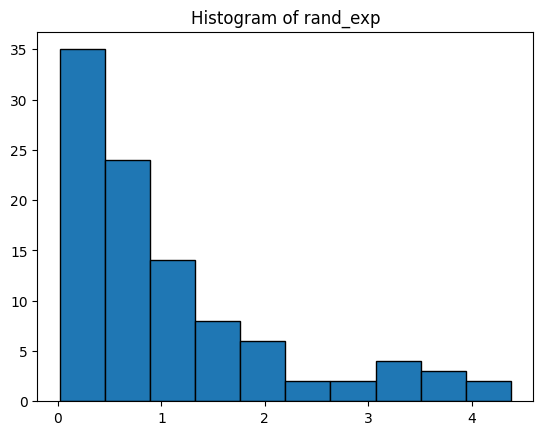

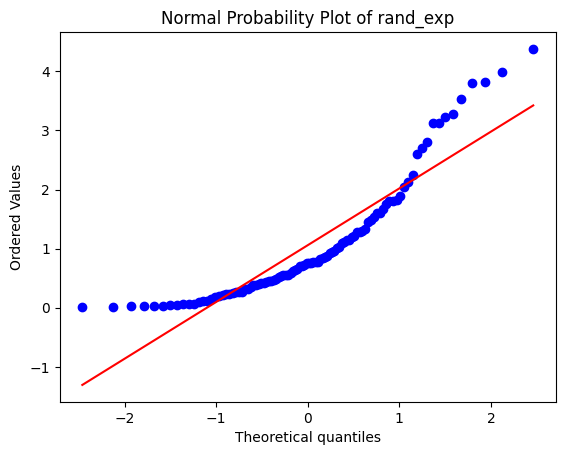

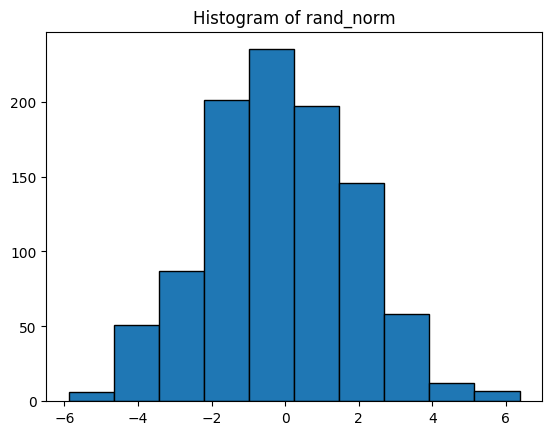

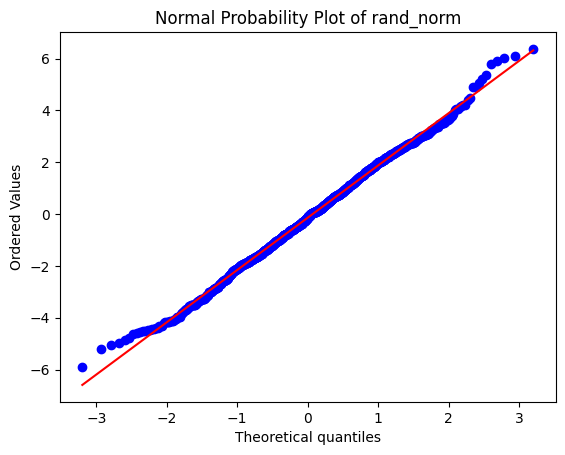

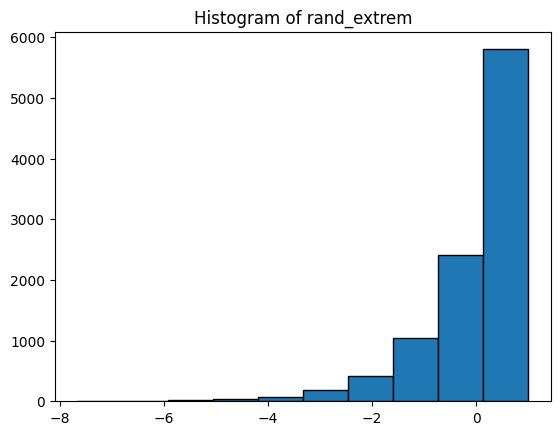

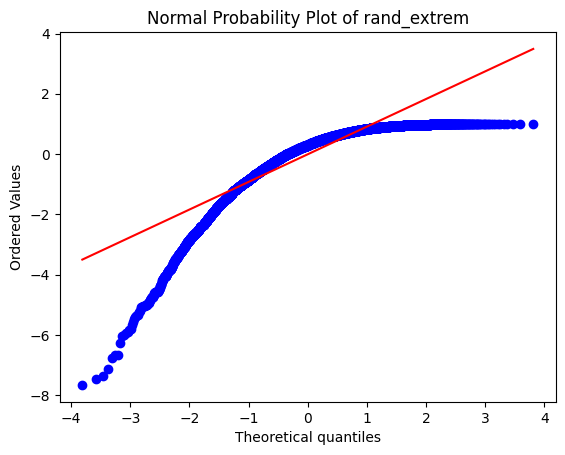

In [7]:
plt.hist(rand_exp, bins=10, edgecolor='black')
plt.title('Histogram of rand_exp')
plt.show()

stats.probplot(rand_exp, dist="norm", plot=plt)
plt.title('Normal Probability Plot of rand_exp')
plt.show()

plt.hist(rand_norm, bins=10, edgecolor='black')
plt.title('Histogram of rand_norm')
plt.show()

stats.probplot(rand_norm, dist="norm", plot=plt)
plt.title('Normal Probability Plot of rand_norm')
plt.show()

plt.hist(rand_extrem, bins=10, edgecolor='black')
plt.title('Histogram of rand_extrem')
plt.show()

stats.probplot(rand_extrem, dist="norm", plot=plt)
plt.title('Normal Probability Plot of rand_extrem')
plt.show()

### 4. Створення вибірки рівномірно розполідених чисел на (0, 1)

In [8]:
# np.random.rand() є аналогом СЛЧИС()/RAND() із Excel
rand_200 = np.random.rand(200)
rand_500 = np.random.rand(500)
rand_5000 = np.random.rand(5000)

### 5. Перевірка належності до розподілів

#### 5.1) Критерій Колмогорова-Смирнова

In [9]:
# Perform the Kolmogorov-Smirnov test
ks_statistic_200, ks_p_value_200 = stats.kstest(rand_200, 'uniform')
ks_statistic_500, ks_p_value_500 = stats.kstest(rand_500, 'uniform')
ks_statistic_5000, ks_p_value_5000 = stats.kstest(rand_5000, 'uniform')

print(f"n=200: KS Statistic: {ks_statistic_200:f}, P-value: {ks_p_value_200:f}")
print(f"n=500: KS Statistic: {ks_statistic_500:f}, P-value: {ks_p_value_500:f}")
print(f"n=5000: KS Statistic: {ks_statistic_5000:f}, P-value: {ks_p_value_5000:f}")

n=200: KS Statistic: 0.078632, P-value: 0.159828
n=500: KS Statistic: 0.029398, P-value: 0.768995
n=5000: KS Statistic: 0.011693, P-value: 0.497463


#### 5.2) Критерій $\omega^2$

In [10]:
def omega_squared_test(data):
    # Calculate the overall mean
    overall_mean = np.mean(data)

    # Calculate the group means and sizes
    group_means = np.array([np.mean(group) for group in data])
    group_sizes = np.array([len(group) for group in data])

    # Calculate the total sum of squares
    total_ss = np.sum([(x - overall_mean)**2 for group in data for x in group])

    # Calculate the between-groups sum of squares
    between_ss = np.sum(group_sizes * (group_means - overall_mean)**2)

    # Calculate omega-squared
    omega_squared = (between_ss - (len(data) - 1) * np.mean(group_sizes)) / (total_ss + np.mean(group_sizes))

    # Perform one-way ANOVA
    f_statistic, p_value = stats.f_oneway(*data)

    return omega_squared, f_statistic, p_value

omega_sq_200, f_stat_200, o_p_val_200 = omega_squared_test(np.array_split(rand_200[:198], 3))
omega_sq_500, f_stat_500, o_p_val_500 = omega_squared_test(np.array_split(rand_500[:498], 3))
omega_sq_5000, f_stat_5000, o_p_val_5000 = omega_squared_test(np.array_split(rand_5000[:4998], 3))

print(f"n=200: Omega-squared: {omega_sq_200:f}, F-statistic: {f_stat_200:f}, p-value: {o_p_val_200:f}")
print(f"n=500: Omega-squared: {omega_sq_500:f}, F-statistic: {f_stat_500:f}, p-value: {o_p_val_500:f}")
print(f"n=5000: Omega-squared: {omega_sq_5000:f}, F-statistic: {f_stat_5000:f}, p-value: {o_p_val_5000:f}")

n=200: Omega-squared: -1.626721, F-statistic: 0.552960, p-value: 0.576144
n=500: Omega-squared: -1.616923, F-statistic: 0.668519, p-value: 0.512929
n=5000: Omega-squared: -1.596947, F-statistic: 0.095963, p-value: 0.908499


#### 5.3) Критерій $\chi^2$

In [11]:
# Get the observed frequencies
observed_200 = np.unique(rand_200, return_counts=True)[1]
observed_500 = np.unique(rand_500, return_counts=True)[1]
observed_5000 = np.unique(rand_5000, return_counts=True)[1]

# Calculate the expected frequencies (assuming homogeneous distribution)
expected_200 = np.ones_like(observed_200) * np.mean(observed_200)
expected_500 = np.ones_like(observed_500) * np.mean(observed_500)
expected_5000 = np.ones_like(observed_5000) * np.mean(observed_5000)

# Perform chi-square test
chi2_statistic_200, c_p_value_200 = stats.chisquare(observed_200, expected_200)
chi2_statistic_500, c_p_value_500 = stats.chisquare(observed_500, expected_500)
chi2_statistic_5000, c_p_value_5000 = stats.chisquare(observed_5000, expected_5000)

print(f"n=200: Chi-square statistic: {chi2_statistic_200:f}, p-value: {c_p_value_200:f}")
print(f"n=500: Chi-square statistic: {chi2_statistic_500:f}, p-value: {c_p_value_500:f}")
print(f"n=5000: Chi-square statistic: {chi2_statistic_5000:f}, p-value: {c_p_value_5000:f}")

n=200: Chi-square statistic: 0.000000, p-value: 1.000000
n=500: Chi-square statistic: 0.000000, p-value: 1.000000
n=5000: Chi-square statistic: 0.000000, p-value: 1.000000


### 6. Робота із вибіркою X

#### 6.1) Завантаження вибірки X

In [12]:
!wget https://raw.githubusercontent.com/Mariya001/Labworks_SMAM/refs/heads/main/Lab1/IDL.csv

--2024-11-15 23:10:30--  https://raw.githubusercontent.com/Mariya001/Labworks_SMAM/refs/heads/main/Lab1/IDL.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1801999 (1.7M) [text/plain]
Saving to: ‘IDL.csv’

IDL.csv             100%[===================>]   1.72M  --.-KB/s    in 0.02s   

2024-11-15 23:10:30 (71.9 MB/s) - ‘IDL.csv’ saved [1801999/1801999]



In [13]:
df = pd.read_csv('IDL.csv')

# Filter rows where the DCOUNTRY column contains 'AUT'
df_filtered = df[df['DCOUNTRY'] == 'AUT']

# Select the column 'DAYS AFTER 105'
X = np.array(df_filtered['DAYS AFTER 105'])

# Display the filtered result
print(X)

[ 548  102  184   51   82  149    5 1004  200  322  260   64  341  356
  214  168  680   65  669 1110  145 1005   50  119  825 1013  419  652
  415   62    8   86  301   15   20  123    4 1676 1408 1965 1124  772
  708 1215 1390 1051  448 1275  161  705 1165  186  210  130   33  417
  587 1938   18  693 1164  751  536  208  896 1446   80  276  937  142
 1057  535  402  265  733  658   12 1255  342 1186 1473   15 1737 1111
  191  218  362  110  399  207  987   10 1030  223   71   34 1012  292
   83  309  331   21  682  390  641  208 1135  603 2244  376   41 1473
  189  135  318  197 1354   21  304  989  124 2216  787  306 2142   10
 1556  890  188 1386  502  870  939  549   13   85  268  970  309  225
  779  161    5  385  194 1639  345  665   72  419  464 1834  145  541
  424 1556  399  219  345  260  579  441  554   72  604  231   25  438
  187  246  349  527  182  981  445  375   95   17  322  741 1011  734
   57  101 1286  478  127   43 1564  342  257  596 1133  198   32  159
  782 

#### 6.2) Критерій Колмогорова-Смирнова

In [14]:
x_lambda_estimate = 1 / np.mean(X)
x_exp_ks_statistic, x_exp_p_value = stats.kstest(X, 'expon', args=(0, 1/x_lambda_estimate))
print(f"Exponential Distribution: KS Statistic = {x_exp_ks_statistic:f}, p-value = {x_exp_p_value:f}")

x_mean_estimate = np.mean(X)
x_std_estimate = np.std(X)
x_normal_ks_statistic, x_normal_p_value = stats.kstest(X, 'norm', args=(x_mean_estimate, x_std_estimate))
print(f"Normal Distribution: KS Statistic = {x_normal_ks_statistic:f}, p-value = {x_normal_p_value:f}")

shape, loc, scale = stats.genextreme.fit(X)
x_extrem_ks_statistic, x_extrem_p_value = stats.kstest(X, 'genextreme', args=(shape, loc, scale))
print(f"GEV Distribution: KS Statistic = {x_extrem_ks_statistic:f}, p-value = {x_extrem_p_value:f}")

Exponential Distribution: KS Statistic = 0.042393, p-value = 0.709040
Normal Distribution: KS Statistic = 0.153745, p-value = 0.000006
GEV Distribution: KS Statistic = 0.549707, p-value = 0.000000


#### 6.3) Критерій $\omega^2$

In [15]:
x_exp_x, x_exp_ecdf_values = ecdf(X)
x_normal_x, x_normal_ecdf_values = ecdf(X)
x_extrem_x, x_extrem_ecdf_values = ecdf(X)
x_lambda_exp = 1 / np.mean(X)
mu, std = np.mean(rand_norm), np.std(X)
x_params_extreme = stats.gumbel_r.fit(X)
x_cdf_exp = stats.expon.cdf(x_exp_x, scale=1/x_lambda_exp)
x_cdf_normal = stats.norm.cdf(x_normal_x, loc=mu, scale=std)
x_cdf_extreme = stats.gumbel_r.cdf(x_extrem_x, *x_params_extreme)
x_omega2_exp, x_o_p_exp = omega_squared(x_exp_ecdf_values, x_cdf_exp)
x_omega2_norm, x_o_p_norm = omega_squared(x_normal_ecdf_values, x_cdf_normal)
x_omega2_extrem, x_o_p_extrem = omega_squared(x_extrem_ecdf_values, x_cdf_extreme)
print(f"ω² for Exponential Distribution: {x_omega2_exp:f}, p-value: {x_o_p_exp}")
print(f"ω² for Normal Distribution: {x_omega2_norm:f}, p-value: {x_o_p_norm}")
print(f"ω² for Extreme Value Distribution: {x_omega2_extrem:f}, p-value: {x_o_p_extrem}")

ω² for Exponential Distribution: 0.054250, p-value: 5.844650817006868e-13
ω² for Normal Distribution: 24.277549, p-value: 0.0
ω² for Extreme Value Distribution: 0.738298, p-value: 5.263130018264242e-171


#### 6.4) Критерій $\chi^2$

In [16]:
x_chi_exp = test_exponential_distribution(X)
x_chi_norm = test_normal_distribution(X)
x_chi_extrem = test_extreme_value_distribution(X)

Exponential Distribution: Chi2 Stat=8.333885, p-value=0.500880
Normal Distribution: Chi2 Stat=156.104142, p-value=0.000000
Extreme Value Distribution: Chi2 Stat=58.729754, p-value=0.000000


#### 6.5) Критерії для рівномірного розподілу

In [17]:
x_ks_statistic, x_ks_p_value = stats.kstest(X, 'uniform')
x_omega_sq, x_f_stat, x_o_p_val = omega_squared_test(np.array_split(X[:len(X) - 2], 3))
x_observed = np.unique(X, return_counts=True)[1]
x_expected = np.ones_like(x_observed) * np.mean(x_observed)
x_chi2_statistic, x_c_p_value = stats.chisquare(x_observed, x_expected)

print(f"X: KS Statistic: {x_ks_statistic:f}, P-value: {x_ks_p_value:f}")
print(f"X: Omega-squared: {x_omega_sq:f}, F-statistic: {x_f_stat:f}, p-value: {x_o_p_val:f}")
print(f"X: Chi-square statistic: {x_chi2_statistic:f}, p-value: {x_c_p_value:f}")

X: KS Statistic: 1.000000, P-value: 0.000000
X: Omega-squared: 0.012703, F-statistic: 1.679411, p-value: 0.188493
X: Chi-square statistic: 24.300752, p-value: 1.000000


### 7. Представлення результатів у табличному вигляді

In [19]:
pd.DataFrame({
    "Перевірка": ["на експоненційний розподіл", "на нормальний розподіл", "на розподіл екстремальних значень", "на рівномірний розподіл", "на рівномірний розподіл", "на рівномірний розподіл", "на експоненційний розподіл", "на нормальний розподіл", "на розподіл екстремальних значень", "на рівномірний розподіл"],
    "Вибірка": ["rand_exp", "rand_norm", "rand_extrem", "rand_200", "rand_500", "rand_5000", "X", "X", "X", "X"],
    "Критерій Колмогорова-Смирнова (p-value)": [f"{el:.3f}" for el in [exp_p_value, normal_p_value, extrem_p_value, ks_p_value_200, ks_p_value_500, ks_p_value_5000, x_exp_p_value, x_normal_p_value, x_extrem_p_value, x_ks_p_value]],
    "омега в квадраті (p-value)": [f"{el:.3f}" for el in [o_p_exp, o_p_norm, o_p_extrem, o_p_val_200, o_p_val_500, o_p_val_5000, x_o_p_exp, x_o_p_norm, x_o_p_extrem, x_o_p_val]],
    "ксі в квадраті (p-value)": [f"{el:.3f}" for el in [chi_exp, chi_norm, chi_extrem, c_p_value_200, c_p_value_500, c_p_value_5000, x_chi_exp, x_chi_norm, x_chi_extrem, x_c_p_value]]})

,Перевірка,Вибірка,Критерій Колмогорова-Смирнова (p-value),омега в квадраті (p-value),ксі в квадраті (p-value)
0,на експоненційний розподіл,rand_exp,0.930,0.014,0.447
1,на нормальний розподіл,rand_norm,0.974,0.000,0.065
2,на розподіл екстремальних значень,rand_extrem,0.827,0.000,0.000
3,на рівномірний розподіл,rand_200,0.160,0.576,1.000
4,на рівномірний розподіл,rand_500,0.769,0.513,1.000
5,на рівномірний розподіл,rand_5000,0.497,0.908,1.000
6,на експоненційний розподіл,X,0.709,0.000,0.501
7,на нормальний розподіл,X,0.000,0.000,0.000
8,на розподіл екстремальних значень,X,0.000,0.000,0.000
9,на рівномірний розподіл,X,0.000,0.188,1.000
